In [42]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statistics

## Structural variant gold set

In [3]:
with open("hsvp.variant.lengths") as file:
    lines = [line.rstrip() for line in file]
sv_lens = list(map(int, lines))

In [4]:
statistics.stdev(sv_lens)

54990.26004894753

In [5]:
np.max(sv_lens)

17373620

In [6]:
np.min(sv_lens)

50

In [8]:
np.mean(sv_lens)

1061.0917464448369

In [2]:
np.median(sv_lens)

NameError: name 'sv_lens' is not defined

## Inversions from valik

In [111]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

c_darkblue = "#4c6c9c"
c_darkgreen = "#5e8f7b"
c_purple = "#947db0"

In [372]:
def read_stellar_output(filename):
    df = pd.read_csv(filename, sep = "\t", header = None)
    df.drop([1, 2, 7], axis = 1, inplace = True) 
    df.columns = ["dname", "dbegin", "dend", "percid", "strand", "attr"]
    df["len"] = np.abs(df["dend"] - df["dbegin"])
    df[['qname','seq2Range', 'evalue', 'cigar', 'mutations']] = df['attr'].str.split(';',expand=True)
    df[["qbegin", "qend"]] = df["seq2Range"].str.removeprefix("seq2Range=").str.split(',',expand=True)
    df.drop(["cigar", "mutations", "evalue", "attr", "seq2Range"], axis = 1, inplace = True)
    for col in ["dbegin", "dend", "qbegin", "qend"]:
        df[col] = pd.to_numeric(df[col])
    return df

In [394]:
def line_params(best_matches):
    i = 0

    x1 = best_matches["dbegin"].iloc[i]
    x2 = best_matches["dend"].iloc[i]
    y1 = best_matches["qbegin"].iloc[i]
    y2 = best_matches["qend"].iloc[i]

    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    return [a, b]

def get_line(a, b):
    y_line = [0, 14000]
    x_line = []
    for y in y_line:
        x_line.append((y - b) / a)
    return x_line

def plot_matches_on_line(matches, best, x_line, y_line):
    for index, row in matches.iterrows():
        plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-')

    for index, row in best.iterrows():
        plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'r-')

    plt.plot(x_line, y_line, 'y-')
    locs, labels = plt.xticks()

    plt.xticks(locs, labels, rotation = 20)

    plt.xlabel("GRCh38")
    plt.ylabel(best["qname"].iloc[0])
    plt.title(best["dname"].iloc[0])
    plt.tight_layout()
    plt.show()

In [395]:
pid = "NA19238"
l = 50
e = "0.02"
variants = read_stellar_output(pid + "_l" + str(l) + "_e" + e + "_var.fp.gff")
mini_variants = variants.head()

In [396]:
len(variants)

32481

In [397]:
split_reads = []
for qname in np.unique(variants["qname"]): 
    query_matches = variants[variants["qname"] == qname]
    for dname in np.unique(query_matches["dname"]):
        chr_query_matches = query_matches[query_matches["dname"] == dname]
        if (len(chr_query_matches) > 3):
            if (len(np.unique(chr_query_matches["strand"])) == 2):
                split_reads.append(qname)
                break

variants = variants[variants['qname'].isin(split_reads)]
len(variants)

31343

In [426]:
best_matches = variants[variants["len"] == np.max(variants["len"])]
best_matches

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend,a,b
6555,chr5,49630768,49631528,98.0289,+,760,m64039_190830_040857/173474075/ccs,1,760,0.998684,-4.956546e+07


In [421]:
a, b = line_params(best_matches)
[a, b]

[0.9986842105263158, -49565463.35789474]

In [425]:
variants = variants.assign(a = lambda x: ((x["qend"] - x["qbegin"]) / (x["dend"] - x["dbegin"])))
variants = variants.assign(b = lambda x: (x["qbegin"] - x["a"] * x["dbegin"]))

variants.head()

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend,a,b
0,chr1,788752,788808,98.2456,-,56,m64039_190830_040857/78318003/ccs,5258,5314,1.0,-783494.0
1,chr1,788752,788808,98.2456,+,56,m64039_190830_040857/74187176/ccs,3297,3353,1.0,-785455.0
2,chr1,788752,788808,98.2456,+,56,m64039_190830_040857/80217145/ccs,5350,5406,1.0,-783402.0
3,chr1,788752,788808,98.2456,-,56,m64039_190830_040857/114491701/ccs,1524,1580,1.0,-787228.0
4,chr1,788752,788808,98.2456,+,56,m64039_190830_040857/111413372/ccs,5973,6029,1.0,-782779.0


In [419]:
longest_match_plus = variants[(variants["qname"] == best_matches["qname"].iloc[0]) & (variants["dname"] == "chr5") & (variants["strand"] == "+")]
longest_match_plus.sort_values('qbegin').head()

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
6555,chr5,49630768,49631528,98.0289,+,760,m64039_190830_040857/173474075/ccs,1,760
6565,chr5,49644048,49644229,98.3516,+,181,m64039_190830_040857/173474075/ccs,1,181
6546,chr5,49622702,49622871,98.2352,+,169,m64039_190830_040857/173474075/ccs,1,170
6574,chr5,49646075,49646256,98.3516,+,181,m64039_190830_040857/173474075/ccs,1,181
6541,chr5,49612238,49612410,98.2658,+,172,m64039_190830_040857/173474075/ccs,54,225


In [420]:
longest_match_minus = variants[(variants["qname"] == best_matches["qname"].iloc[0]) & (variants["dname"] == "chr5") & (variants["strand"] == "-")]
longest_match_minus.sort_values("qbegin").head()

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
6480,chr5,47296894,47297169,98.1884,-,275,m64039_190830_040857/173474075/ccs,1,275
6491,chr5,47308164,47308329,98.1927,-,165,m64039_190830_040857/173474075/ccs,1,166
6482,chr5,47298694,47298859,98.1927,-,165,m64039_190830_040857/173474075/ccs,1,166
6492,chr5,47308384,47308824,98.1859,-,440,m64039_190830_040857/173474075/ccs,184,624
6581,chr5,49650313,49650488,98.2954,-,175,m64039_190830_040857/173474075/ccs,326,501


In [414]:
x_line = get_line(a, b)
y_line = [0, 14000]
x_line

[49630766.99868248, 49644785.44400527]

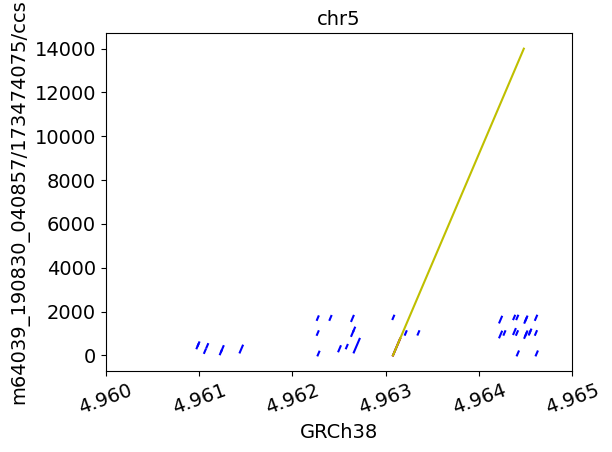

In [415]:
plot_matches_on_line(longest_match_plus, best_matches, x_line, y_line)

### Inversions from bash workflow

In [245]:
chr_id=4
read_id=5927

frames = []
strand = "plus"
for strand in ["plus", "minus"]:
    filename = "chr" + str(chr_id) + "_" + str(read_id) + "_" + strand + "_var.gff"
    frames.append(read_stellar_output(filename))

df = pd.concat(frames)
df

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
0,chr4,21582029,21582088,98.3333,+,59,m54329U_190906_205127/101581354/ccs,14165,14224
1,chr4,21582029,21582088,98.3333,+,59,m54329U_190906_205127/101581354/ccs,13861,13919
2,chr4,49633388,49633446,98.3050,+,58,m54329U_190906_205127/101581354/ccs,13869,13926
3,chr4,49633388,49633452,98.4615,+,64,m54329U_190906_205127/101581354/ccs,7698,7762
4,chr4,49633388,49633452,98.4615,+,64,m54329U_190906_205127/101581354/ccs,3683,3747
...,...,...,...,...,...,...,...,...,...
64,chr4,49149460,49149520,98.3606,-,60,m54329U_190906_205127/101581354/ccs,7072,7132
65,chr4,49149461,49149525,98.4615,-,64,m54329U_190906_205127/101581354/ccs,7698,7762
66,chr4,49150504,49150562,98.3050,-,58,m54329U_190906_205127/101581354/ccs,6453,6511
67,chr4,49154226,49154285,98.3333,-,59,m54329U_190906_205127/101581354/ccs,6452,6511


### Clamp variable based on longest match

In [291]:
df = df[df["dbegin"] > 40000000]
plus = df[df["strand"] == "+"]
minus = df[df["strand"] == "-"]

In [294]:
print("Minus strand var range before clamp\t" + str(np.max(minus["dbegin"]) - np.min(minus["dbegin"])))
longest_match = minus[minus["len"] == np.max(minus["len"])]
min_begin = longest_match.dbegin.iloc[0] - int(longest_match.qbegin.iloc[0] * 1.5)
max_end = longest_match.dend.iloc[0] + int(longest_match.qend.iloc[0] * 1.5)
minus_best = minus[minus["dbegin"] > min_begin]
minus_best = minus_best[minus_best["dend"] < max_end]
print("Minus strand var range after clamp\t" + str(np.max(minus_best["dbegin"]) - np.min(minus_best["dbegin"])))

Minus strand var range before clamp	61664
Minus strand var range after clamp	16811


In [295]:
minus_best = minus_best[minus_best["len"] > 70]
minus_best

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
45,chr4,49138030,49138105,98.6842,-,75,m54329U_190906_205127/101581354/ccs,6072,6147


In [296]:
print("Plus strand var range before clamp\t" + str(np.max(plus["dbegin"]) - np.min(plus["dbegin"])))

Plus strand var range before clamp	18045


In [297]:
plus[plus["len"] == np.max(plus["len"])]

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
14,chr4,49635174,49635241,98.5294,+,67,m54329U_190906_205127/101581354/ccs,1188,1255
15,chr4,49635174,49635241,98.5294,+,67,m54329U_190906_205127/101581354/ccs,6456,6523
26,chr4,49639289,49639356,98.5294,+,67,m54329U_190906_205127/101581354/ccs,6452,6519


In [298]:
plus_best = plus[plus["len"] == np.max(plus["len"])].drop(15)
plus_best

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend
14,chr4,49635174,49635241,98.5294,+,67,m54329U_190906_205127/101581354/ccs,1188,1255
26,chr4,49639289,49639356,98.5294,+,67,m54329U_190906_205127/101581354/ccs,6452,6519


In [305]:
print("Plus strand var range after clamp\t" + str(np.max(plus["dbegin"]) - np.min(plus["dbegin"])))

Plus strand var range after clamp	18045


In [371]:
a, b = line_params(plus_best)

In [335]:
locs

array([49630000., 49632500., 49635000., 49637500., 49640000., 49642500.,
       49645000., 49647500., 49650000., 49652500.])

In [336]:
y_line = [0, 14000]
x_line = []
for y in y_line:
    x_line.append((y - b) / a)
x_line

[49632837.0, 49646837.0]

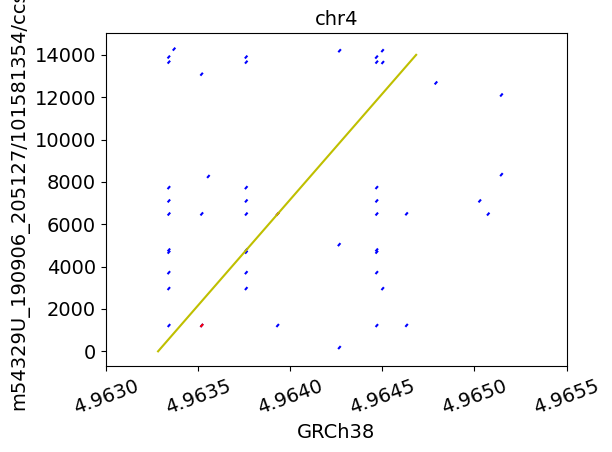

In [337]:
for index, row in plus.iterrows():
    plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-')

for index, row in plus_best.iterrows():
    plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'r-')

plt.plot(x_line, y_line, 'y-')
locs, labels = plt.xticks()

plt.xticks(locs, labels, rotation = 20)

plt.xlabel("GRCh38")
plt.ylabel(df["qname"].iloc[0])
plt.title(df["dname"].iloc[0])
plt.tight_layout()

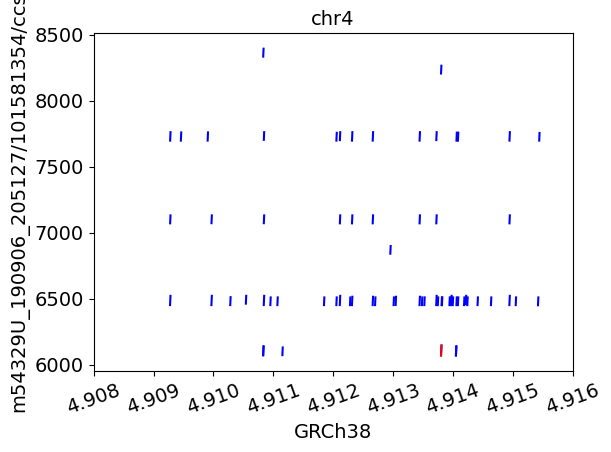

In [303]:
for index, row in minus.iterrows():
    plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-')

for index, row in minus_best.iterrows():
    plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'r-')

locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation = 20)

plt.xlabel("GRCh38")
plt.ylabel(df["qname"].iloc[0])
plt.title(df["dname"].iloc[0])
plt.tight_layout()

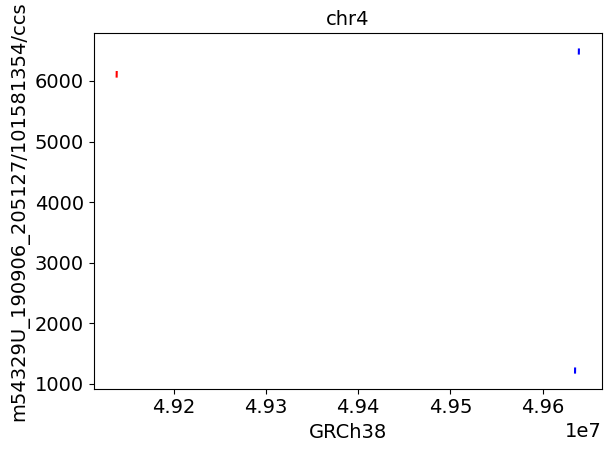

In [304]:
for index, row in plus_best.iterrows():
    plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-')

for index, row in minus_best.iterrows():
    plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'r-')

locs, labels = plt.xticks()
#plt.xticks(locs, (locs - 49000000), rotation = 20)

plt.xlabel("GRCh38")
plt.ylabel(df["qname"].iloc[0])
plt.title(df["dname"].iloc[0])
#plt.legend(handles=[high_entropy, low_entropy])
plt.tight_layout()
#plt.savefig(outfile, dpi = 200)
    